In [1]:
%load_ext autoreload
%autoreload 2

from tqdm import tqdm
import pandas as pd
import numpy as np
import gzip
import json
import math
from datetime import datetime
import seaborn as sns
import matplotlib.dates as mdates
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display
%matplotlib inline
import pickle

import sys
sys.path.append('..')
from helper.rl_framework import *
from helper.orderbook_container import OrderbookContainer
from helper.manage_orderbooks import *
from helper.orderbook_trader import *
# from helper.RL_Agent import RLAgent
# from agents.NN_Agent import RLAgent_NN
from agents.BatchTree_Agent import RLAgent_BatchTree
from train_BatchTree import train_RL, trainer

Using TensorFlow backend.


In [2]:
V=100
T=4
P=15

filename_train = '/home/axel/data/small/obs_2016-11_USDT_BTC_maxVol100.dict'

actions = list(np.linspace(-0.4, 1.0, num=15))
print("Actions: ", ", ".join(["{:1.2f}".format(a) for a in actions]))

episodes_train = OrderbookEpisodesGenerator(filename=filename_train, episode_length=T*P)
print("Length of episodes_train: {}".format(len(episodes_train)))

Actions:  -0.40, -0.30, -0.20, -0.10, -0.00, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1.00
Length of episodes_train: 541


### Settings

In [3]:
# cached_episodes = list(episodes_train[:20])
# pickle.dump( cached_episodes, open( "cached_episodes.p", "wb" ) )
data = pickle.load( open( "cached_episodes.p", "rb" ) )
data[0][0].timestamp

'2016-11-08T10:00'

In [4]:
V=100
T=4
P=15

random.seed(13)
np.random.seed(13)
# plot_episode(episodes_train[1], volume=100)
data[0][0].timestamp
agent = trainer(orderbooks=data[:1], V=V, T=T, actions=actions,
                   period_length=P, epochs=20, random_start=True,
                   state_variables=['volume', 'time'])

RL-Type: <class 'agents.BatchTree_Agent.RLAgent_BatchTree'>


100%|██████████| 20/20 [00:51<00:00,  2.62s/it]


brain.samples.shape (300, 8)


t1, v10.0  -  action: #0=-0.4
['0.0073', '0.0073', '0.0073', '0.0073', '0.0073', '0.0073', '0.0073', '0.0073', '0.0073', '0.0073', '0.0073', '0.0073', '0.0073', '0.0073', '0.0073']
t1, v100.0  -  action: #9=0.5
['0.8103', '0.8103', '0.8103', '0.8103', '0.8103', '0.8103', '0.8103', '0.8103', '0.3066', '0.2625', '0.3030', '0.3091', '0.3235', '0.3287', '0.3443']
t2, v20.0  -  action: #0=-0.4
['0.0350', '0.0350', '0.0350', '0.0350', '0.0350', '0.0362', '0.0362', '0.0403', '0.0403', '0.0458', '0.0484', '0.0484', '0.0484', '0.0484', '0.0484']
t4, v20.0  -  action: #0=-0.4
['0.0339', '0.0339', '0.0339', '0.0339', '0.0339', '0.0350', '0.0350', '0.0391', '0.0391', '0.0447', '0.0484', '0.0484', '0.0484', '0.0484', '0.0484']


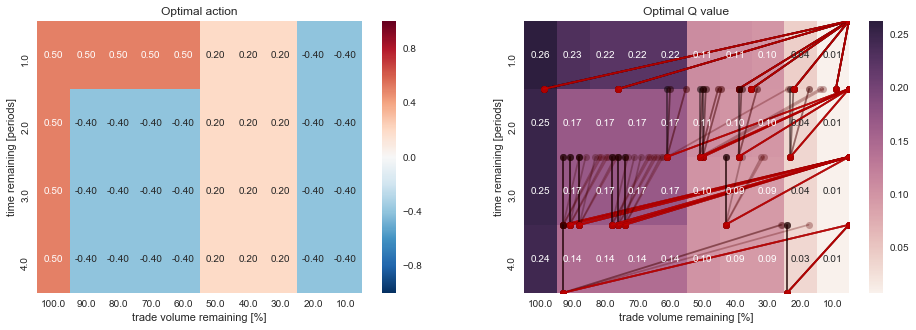

In [5]:
agent.heatmap_Q(show_traces=True)

In [6]:
costs = agent.evaluate(testdata=data[:3])
display(costs)
display(costs.mean())

3it [00:02,  1.36it/s]


,BatchTree_Agent
2016-11-08T10:00,0.172375
2016-11-08T11:01,0.164635
2016-11-08T12:01,0.331701


BatchTree_Agent    0.222904
dtype: float64